## Imports

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import pickle
import sys
import os
import json
import math
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from pathlib import Path
from collections import defaultdict
pd.set_option('display.max_columns', 500)

In [4]:
import scipy
from scipy.cluster import hierarchy as hc
from rfpimp import (importances, dropcol_importances, feature_corr_matrix, 
                    plot_corr_heatmap, plot_importances, oob_importances)

In [5]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport

In [6]:
# If input or output variables using extraneous memory run below specify (in or out)
# %reset -f out
# %reset -f in

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def get_var_sizes(local_vars = locals().items(), max_num=12):
    # if sys not imported then import it
    # after sys imported use 'copy' in sys.modules
    if "sys" not in dir():
        import sys
        
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in local_vars),
                             key= lambda x: -x[1])[:max_num]:
        print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

In [9]:
# %reset -f out
get_var_sizes()

                        df_raw:  5.2 MiB
         RandomForestRegressor:  1.4 KiB
        RandomForestClassifier:  1.0 KiB
          ClassificationReport:  1.0 KiB
                          _iii:  913.0 B
                           _i6:  913.0 B
               NamespaceMagics:  888.0 B
                          Path:  888.0 B
                   defaultdict:  400.0 B
                           _i3:  334.0 B
                           _i4:  253.0 B
                           _i5:  232.0 B


## Load Data

In [10]:
df_raw = pd.read_csv("vgsales.csv")

In [11]:
# Has year 2020 and game low sales only in North Amer. so dropped
df_raw = df_raw.drop(5957)

In [12]:
df = df_raw

In [13]:
# Goes NA, EU, JP
populations = [575, 510, 125]
# populations = [i*1000000 for i in [575, 125, 510]]

In [14]:
# Sales as percentage of global sales
df['NA_perc'] = df['NA_Sales']/df['Global_Sales'] * 100
df['EU_perc'] = df['EU_Sales']/df['Global_Sales'] * 100
df['JP_perc'] = df['JP_Sales']/df['Global_Sales'] * 100
df['Other_perc'] = df['Other_Sales']/df['Global_Sales'] * 100

In [15]:
# Calculates sales/population
df['NA_norm'] = df['NA_Sales']/populations[0] * 100
df['EU_norm'] = df['EU_Sales']/populations[1] * 100
df['JP_norm'] = df['JP_Sales']/populations[2] * 100

In [16]:
# Maximum value for sales normalized to population
df['Wtd_sales_max'] = df.loc[:,['NA_norm', 'EU_norm', 'JP_norm']].idxmax(axis=1)

In [17]:
df.head().T

,0,1,2,3,4
Rank,1,2,3,4,5
Name,Wii Sports,Super Mario Bros.,Mario Kart Wii,Wii Sports Resort,Pokemon Red/Pokemon Blue
Platform,Wii,NES,Wii,Wii,GB
Year,2006,1985,2008,2009,1996
Genre,Sports,Platform,Racing,Sports,Role-Playing
Publisher,Nintendo,Nintendo,Nintendo,Nintendo,Nintendo
NA_Sales,41.49,29.08,15.85,15.75,11.27
EU_Sales,29.02,3.58,12.88,11.01,8.89
JP_Sales,3.77,6.81,3.79,3.28,10.22
Other_Sales,8.46,0.77,3.31,2.96,1


## EDA

### Setup

In [18]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

### Pre-explore

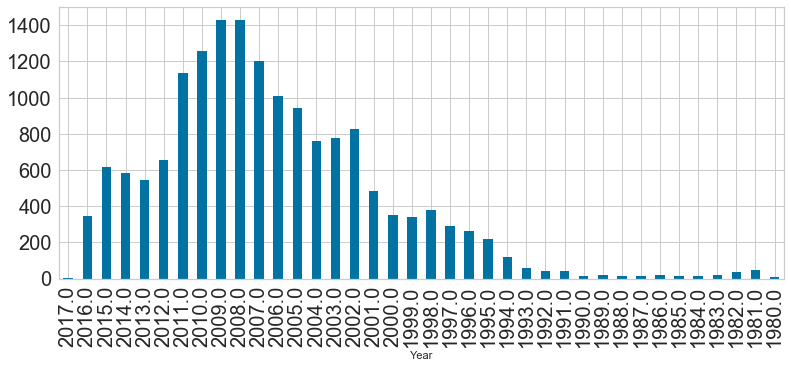

In [19]:
df.groupby('Year').count()['Genre'][::-1].plot.bar(figsize=(13,5), fontsize=20)
plt.savefig("vg_year_counts.png", bbox_inches='tight')

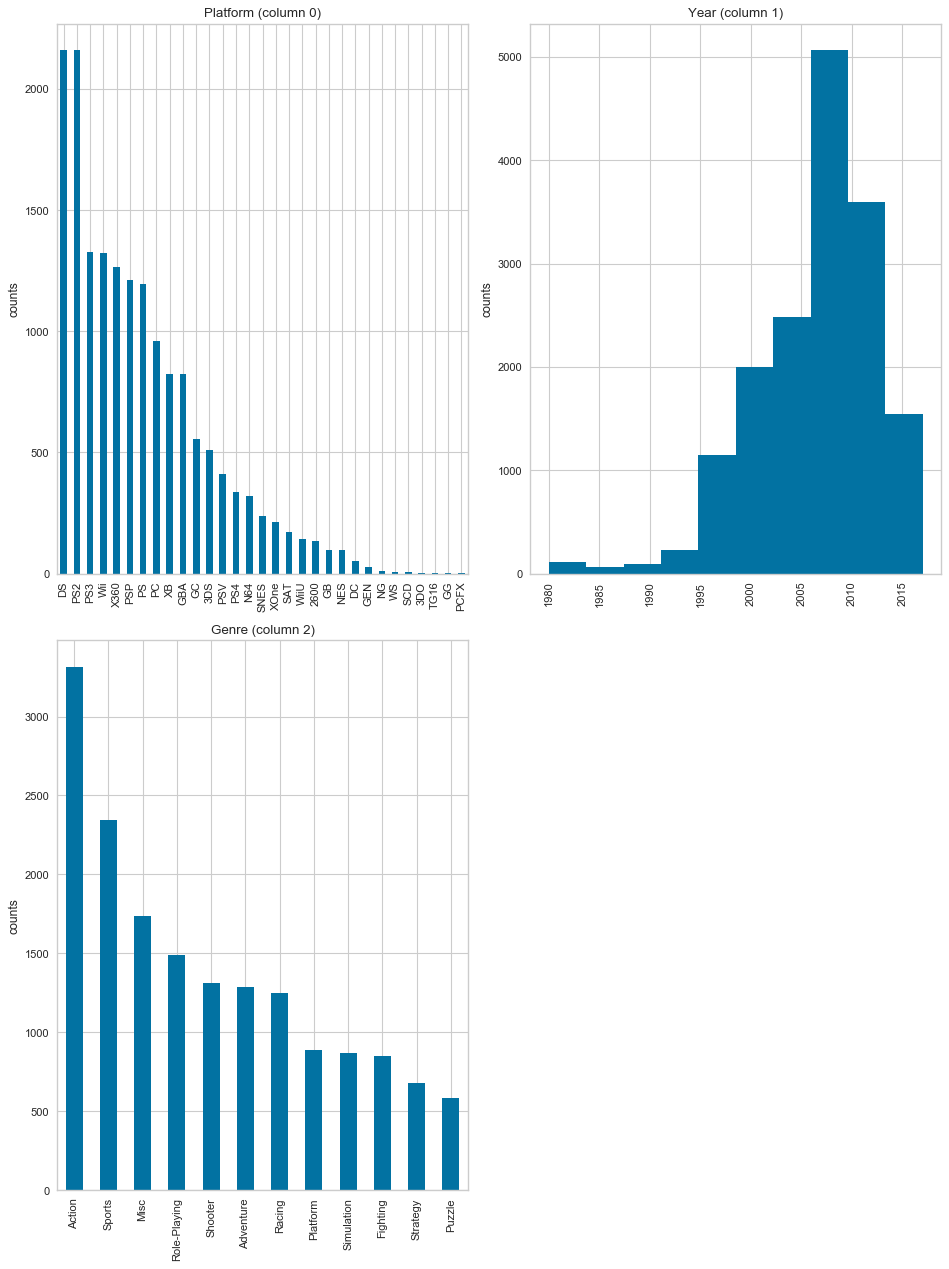

In [21]:
plotPerColumnDistribution(df_raw.iloc[:,0:6], 8, 2)

### Major differences between NA, EU, and JP markets? and What video game genres are trending in each market?

TODO: Distribution of Sales Revenue (by region)  
TODO: Total Revenue by Region and Year

####  Total sales in each Genre

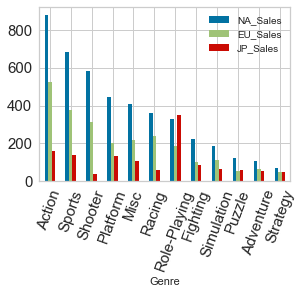

In [20]:
df.groupby('Genre').sum()[['NA_Sales','EU_Sales', 'JP_Sales']].sort_values('NA_Sales', ascending=False).plot.bar(figsize=(4.5,3.2),fontsize=15, rot=70)
plt.savefig("Sales_by_genre.png", pad_inches=0.1, bbox_inches='tight')

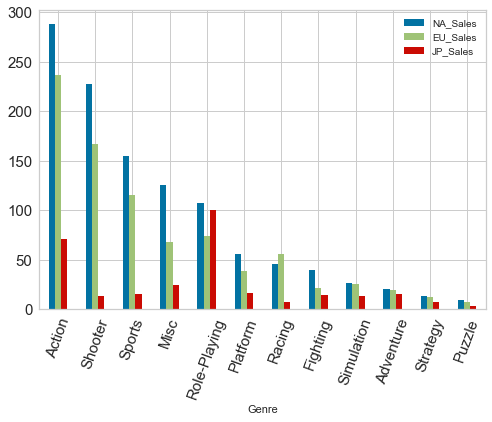

In [21]:
df[df['Year'] >=2010].groupby('Genre').sum()[['NA_Sales','EU_Sales', 'JP_Sales']].sort_values('NA_Sales', ascending=False).plot.bar(fontsize=15, rot=70)

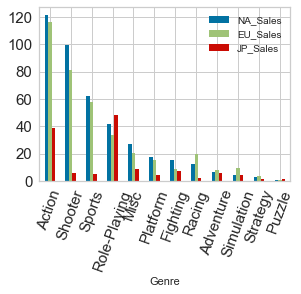

In [22]:
df[df['Year'] >=2013].groupby('Genre').sum()[['NA_Sales','EU_Sales', 'JP_Sales']].sort_values('NA_Sales', ascending=False).plot.bar(figsize=(4.5,3.2), fontsize=15, rot=70)
plt.savefig("Sales_by_genre_recent.png", pad_inches=0.1, bbox_inches='tight')

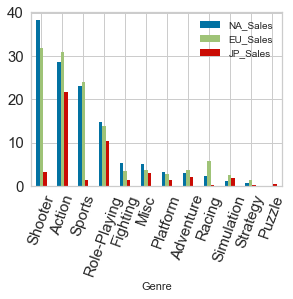

In [23]:
df[df['Year'] >=2015].groupby('Genre').sum()[['NA_Sales','EU_Sales', 'JP_Sales']].sort_values('NA_Sales', ascending=False).plot.bar(figsize=(4.5,3.2), fontsize=15, rot=70)
plt.savefig("Sales_by_genre_last2yr.png", pad_inches=0.1, bbox_inches='tight')

####  Total sales in each Genre (normalized by population)

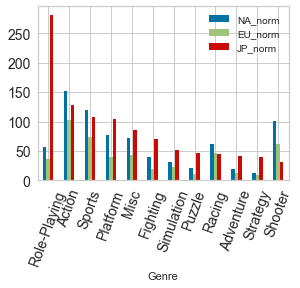

In [24]:
df.groupby('Genre').sum()[['NA_norm','EU_norm', 'JP_norm']].sort_values('JP_norm', ascending=False).plot.bar(figsize=(4.5,3.2), fontsize=14, rot=70)
plt.savefig("Norm_Sales_by_genre.png", pad_inches=0.1, bbox_inches='tight')

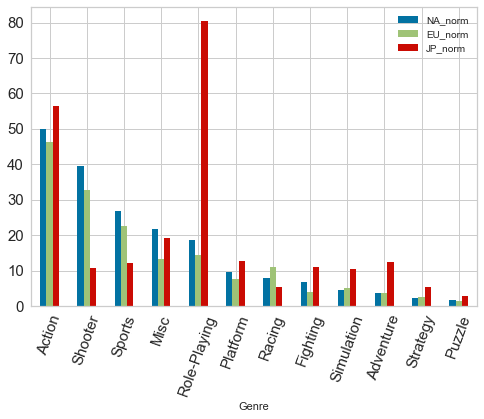

In [25]:
df[df['Year'] >=2010].groupby('Genre').sum()[['NA_norm','EU_norm', 'JP_norm']].sort_values('NA_norm', ascending=False).plot.bar(fontsize=15, rot=70)

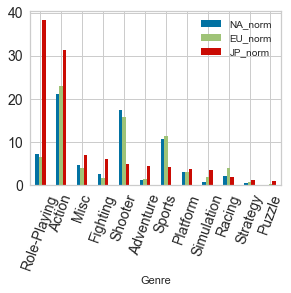

In [26]:
df[df['Year'] >=2013].groupby('Genre').sum()[['NA_norm','EU_norm', 'JP_norm']].sort_values('JP_norm', ascending=False).plot.bar(figsize=(4.5,3.2), fontsize=14, rot=70)
plt.savefig("Norm_Sales_by_genre_recent.png", pad_inches=0.1, bbox_inches='tight')

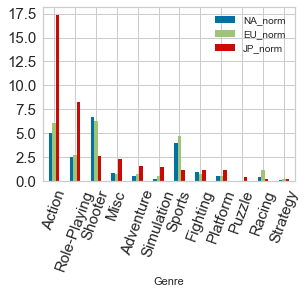

In [27]:
df[df['Year'] >=2015].groupby('Genre').sum()[['NA_norm','EU_norm', 'JP_norm']].sort_values('JP_norm', ascending=False).plot.bar(figsize=(4.5,3.2), fontsize=15, rot=70)
plt.savefig("Norm_Sales_by_genre_last2yr.png", pad_inches=0.1, bbox_inches='tight')

####  Total sales in each Platform

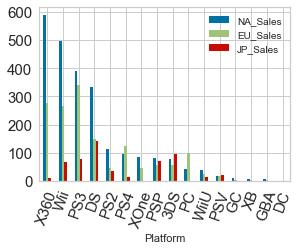

In [28]:
df[df['Year'] >=2006].groupby('Platform').sum()[['NA_Sales','EU_Sales', 'JP_Sales']].sort_values('NA_Sales', ascending=False).plot.bar(figsize=(4.5,3.2), fontsize=15, rot=70)
plt.savefig("Sales_by_platform.png", pad_inches=0.1, bbox_inches='tight')

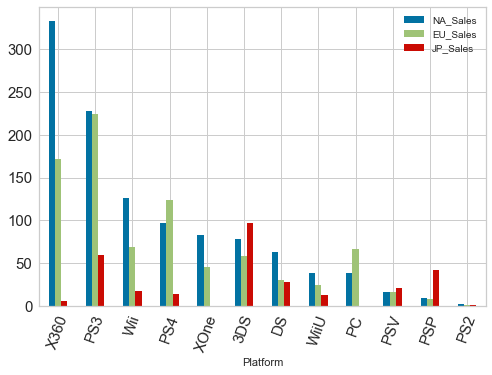

In [29]:
df[df['Year'] >=2010].groupby('Platform').sum()[['NA_Sales','EU_Sales', 'JP_Sales']].sort_values('NA_Sales', ascending=False).plot.bar(fontsize=15, rot=70)

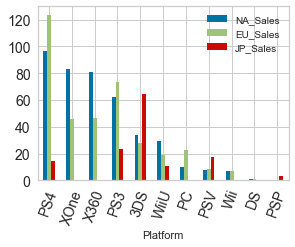

In [30]:
df[df['Year'] >=2013].groupby('Platform').sum()[['NA_Sales','EU_Sales', 'JP_Sales']].sort_values('NA_Sales', ascending=False).plot.bar(figsize=(4.5,3.2), fontsize=14, rot=70)
plt.savefig("Sales_by_platform_recent.png", pad_inches=0.1, bbox_inches='tight')

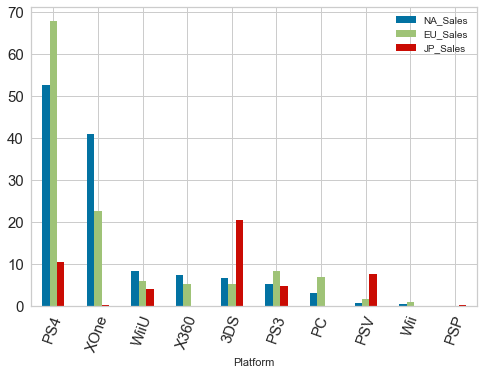

In [31]:
df[df['Year'] >=2015].groupby('Platform').sum()[['NA_Sales','EU_Sales', 'JP_Sales']].sort_values('NA_Sales', ascending=False).plot.bar(fontsize=15, rot=70)

####  Total sales in each Platform (normalized by population)

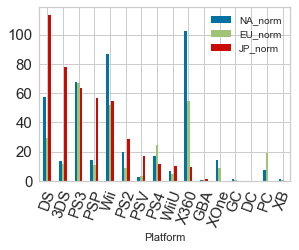

In [32]:
df[df['Year'] >=2006].groupby('Platform').sum()[['NA_norm','EU_norm', 'JP_norm']].sort_values('JP_norm', ascending=False).plot.bar(figsize=(4.5,3.2), fontsize=15, rot=70)
plt.savefig("Norm_Sales_by_platform.png", pad_inches=0.1, bbox_inches='tight')

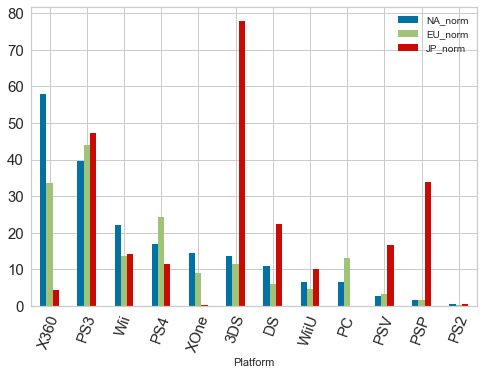

In [33]:
df[df['Year'] >=2010].groupby('Platform').sum()[['NA_norm','EU_norm', 'JP_norm']].sort_values('NA_norm', ascending=False).plot.bar(fontsize=15, rot=70)

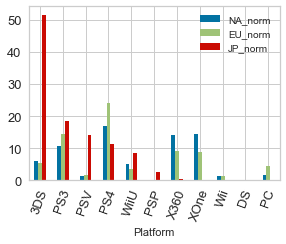

In [34]:
df[df['Year'] >=2013].groupby('Platform').sum()[['NA_norm','EU_norm', 'JP_norm']].sort_values('JP_norm', ascending=False).plot.bar(figsize=(4.5,3.2), fontsize=13, rot=70)
plt.savefig("Norm_Sales_by_genre_recent.png", pad_inches=0.1, bbox_inches='tight')

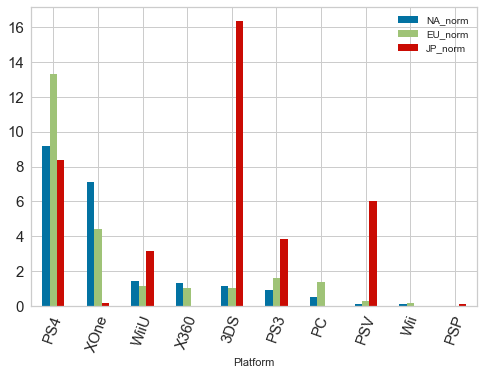

In [35]:
df[df['Year'] >=2015].groupby('Platform').sum()[['NA_norm','EU_norm', 'JP_norm']].sort_values('NA_norm', ascending=False).plot.bar(fontsize=15, rot=70)

####  Total sales in each Publisher

In [36]:
df['Publ_short'] = df.apply(lambda x: str(x['Publisher'])[0:14], axis=1)

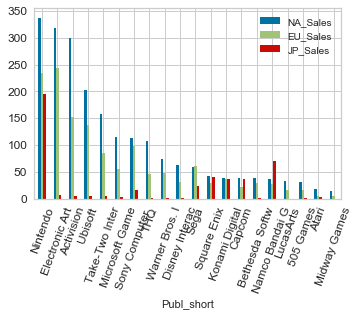

In [37]:
df[df['Year'] >=2006].groupby('Publ_short').sum()[['NA_Sales','EU_Sales', 'JP_Sales']].sort_values('NA_Sales', ascending=False)[:20].plot.bar(figsize=(5.5,3.5), fontsize=12, rot=70)
plt.savefig("Publisher_by_platform.png", pad_inches=0.1, bbox_inches='tight')

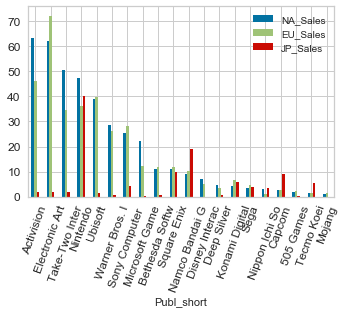

In [38]:
df[df['Year'] >=2013].groupby('Publ_short').sum()[['NA_Sales','EU_Sales', 'JP_Sales']].sort_values('NA_Sales', ascending=False)[:20].plot.bar(figsize=(5.5,3.5), fontsize=12, rot=70)

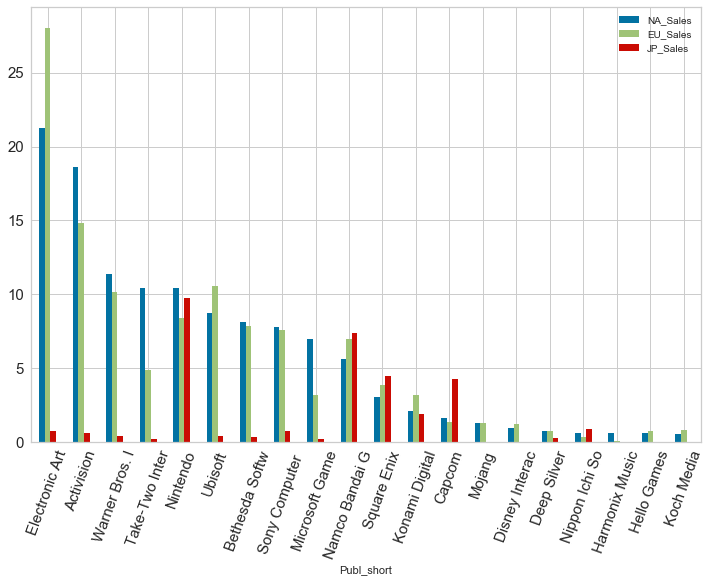

In [39]:
df[df['Year'] >=2015].groupby('Publ_short').sum()[['NA_Sales','EU_Sales', 'JP_Sales']].sort_values('NA_Sales', ascending=False)[:20].plot.bar(figsize=(12,8), fontsize=15, rot=70)

####  Total sales in each Publisher (normalized by population)

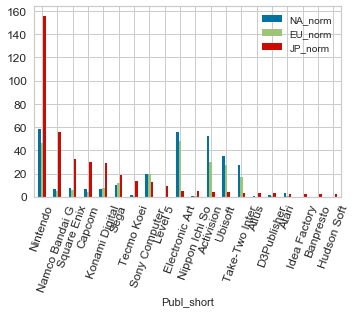

In [40]:
df[df['Year'] >=2006].groupby('Publ_short').sum()[['NA_norm','EU_norm', 'JP_norm']].sort_values('JP_norm', ascending=False)[:20].plot.bar(figsize=(5.5,3.5), fontsize=12, rot=70)
plt.savefig("Norm_Publisher_by_platform.png", pad_inches=0.1, bbox_inches='tight')

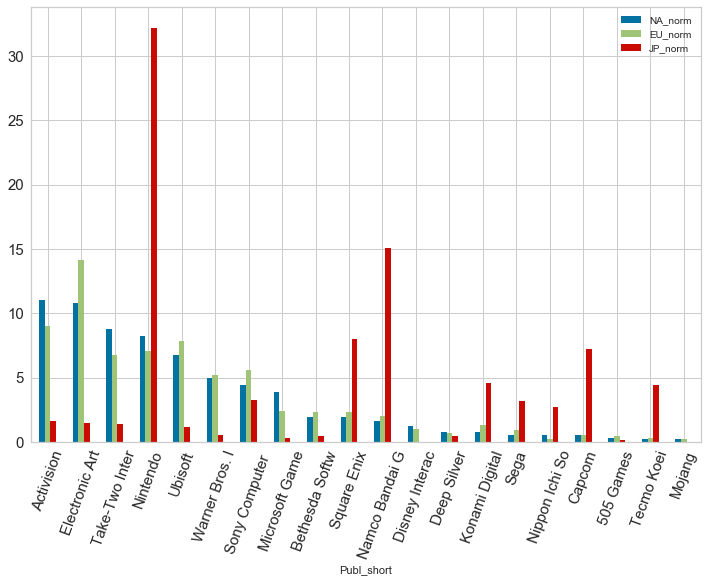

In [41]:
df[df['Year'] >=2013].groupby('Publ_short').sum()[['NA_norm','EU_norm', 'JP_norm']].sort_values('NA_norm', ascending=False)[:20].plot.bar(figsize=(12,8), fontsize=15, rot=70)

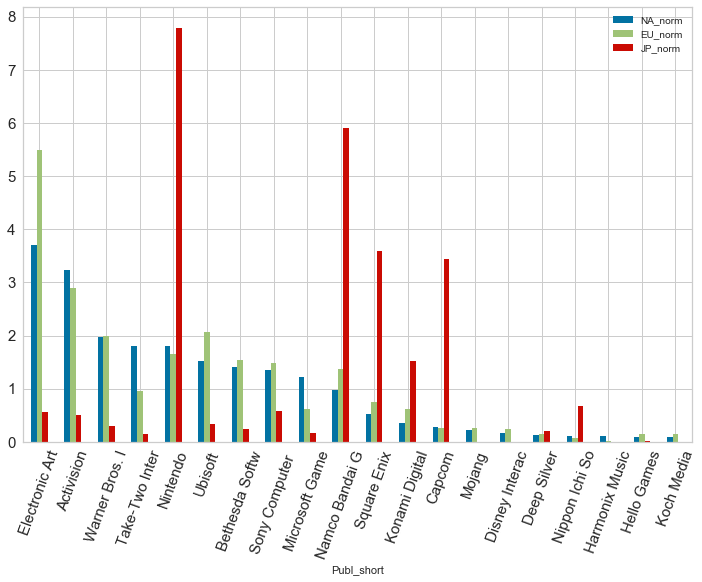

In [42]:
df[df['Year'] >=2015].groupby('Publ_short').sum()[['NA_norm','EU_norm', 'JP_norm']].sort_values('NA_norm', ascending=False)[:20].plot.bar(figsize=(12,8), fontsize=15, rot=70)

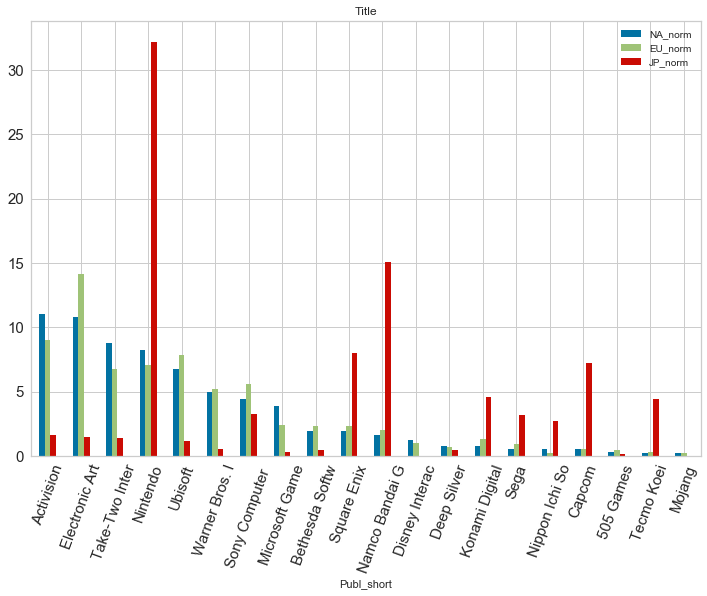

In [43]:
ax = df[df['Year'] >=2013].groupby('Publ_short').sum()[['NA_norm','EU_norm', 'JP_norm']].sort_values('NA_norm', ascending=False)[:20].plot.bar(figsize=(12,8), fontsize=15, rot=70)
ax.set_title("Title")
ax

#### Total sales by Platform for specific Publishers (that I noticed did well with Japanese sales)

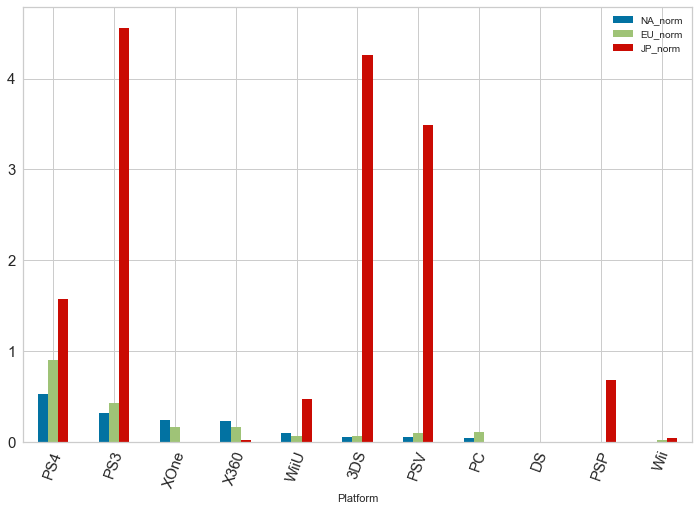

In [44]:
df[(df['Year'] >=2013) & (df['Publ_short'] == 'Namco Bandai G')].groupby('Platform').sum()[['NA_norm','EU_norm', 'JP_norm']].sort_values('NA_norm', ascending=False)[:20].plot.bar(figsize=(12,8), fontsize=15, rot=70)

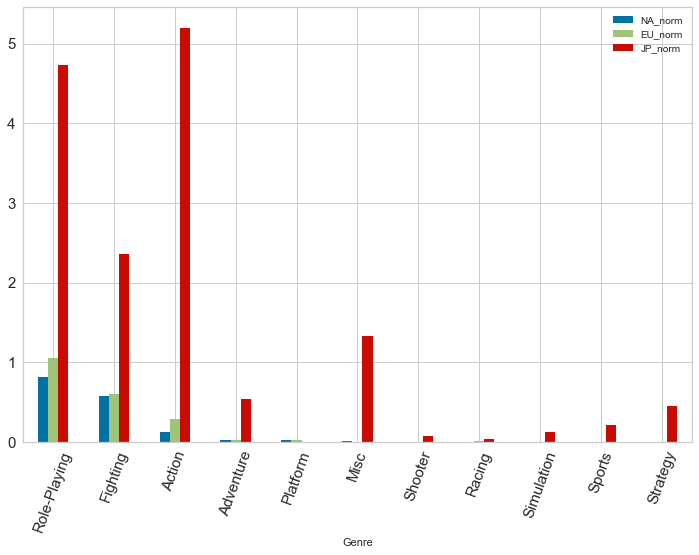

In [45]:
df[(df['Year'] >=2013) & (df['Publ_short'] == 'Namco Bandai G')].groupby('Genre').sum()[['NA_norm','EU_norm', 'JP_norm']].sort_values('NA_norm', ascending=False)[:20].plot.bar(figsize=(12,8), fontsize=15, rot=70)

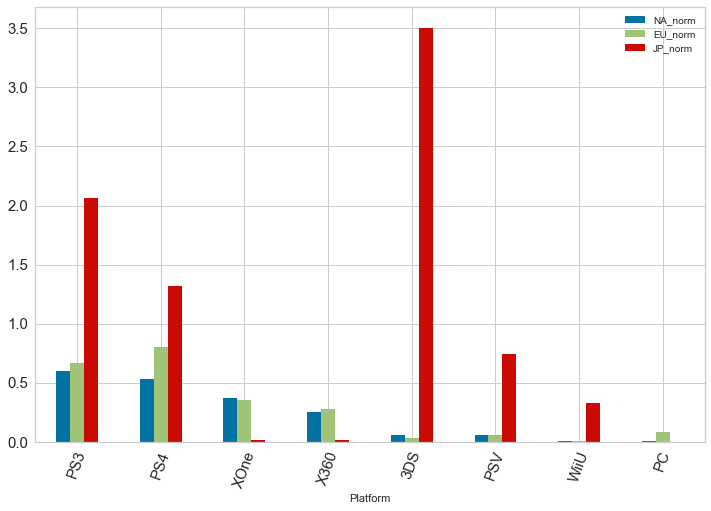

In [46]:
df[(df['Year'] >=2013) & (df['Publ_short'] == 'Square Enix')].groupby('Platform').sum()[['NA_norm','EU_norm', 'JP_norm']].sort_values('NA_norm', ascending=False)[:20].plot.bar(figsize=(12,8), fontsize=15, rot=70)

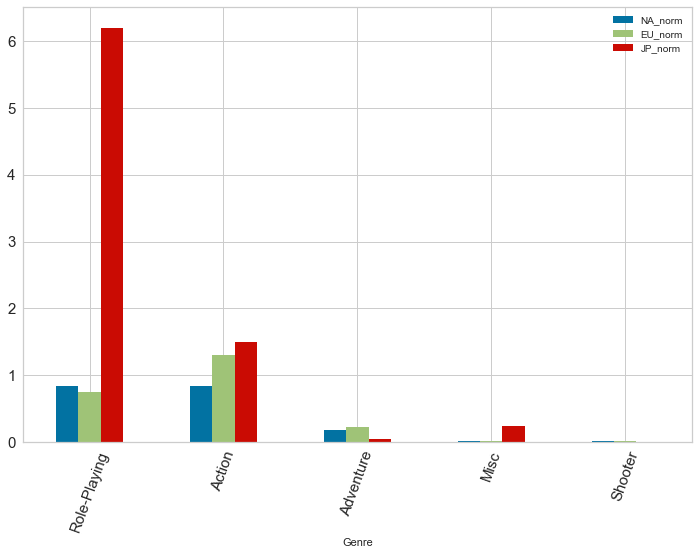

In [47]:
df[(df['Year'] >=2013) & (df['Publ_short'] == 'Square Enix')].groupby('Genre').sum()[['NA_norm','EU_norm', 'JP_norm']].sort_values('NA_norm', ascending=False)[:20].plot.bar(figsize=(12,8), fontsize=15, rot=70)

### What features about a video game are most indicative of its success?

#### Dendogram

In [49]:
df_hc = df_raw.iloc[:,1:6].dropna()

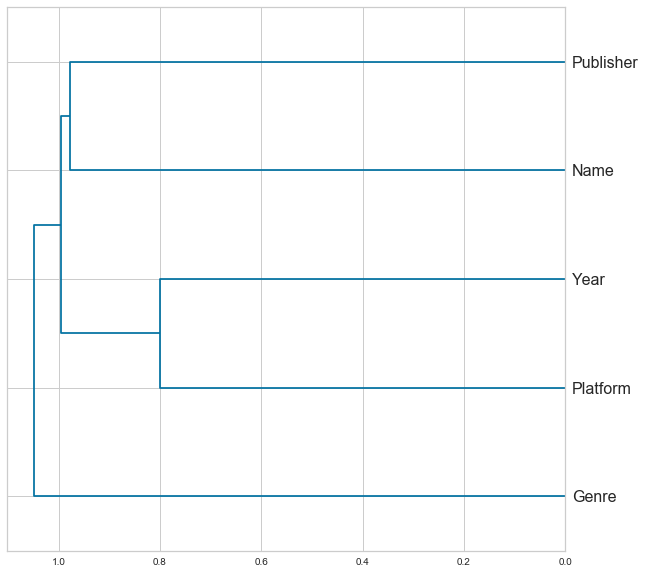

In [50]:
corr = np.round(scipy.stats.spearmanr(df_hc).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(10,10))
dendrogram = hc.dendrogram(z, labels=df_hc.columns, orientation='left', leaf_font_size=16)
plt.savefig('dendogram_vg.png', bbox_inches='tight')

In [51]:
df[0:20]

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,NA_perc,EU_perc,JP_perc,Other_perc,NA_norm,EU_norm,JP_norm,Wtd_sales_max,Publ_short
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,50.145033,35.073725,4.556442,10.224801,7.215652,5.690196,3.016,NA_norm,Nintendo
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,72.266402,8.896620,16.923459,1.913519,5.057391,0.701961,5.448,JP_norm,Nintendo
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,44.249023,35.957566,10.580681,9.240648,2.756522,2.525490,3.032,JP_norm,Nintendo
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,47.727273,33.363636,9.939394,8.969697,2.739130,2.158824,2.624,NA_norm,Nintendo
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,35.926044,28.339178,32.578897,3.187759,1.960000,1.743137,8.176,JP_norm,Nintendo
5,6,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26,76.668870,7.468605,13.945803,1.916722,4.034783,0.443137,3.376,NA_norm,Nintendo
6,7,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01,37.920693,30.756415,21.659447,9.663446,1.979130,1.809804,5.200,JP_norm,Nintendo
7,8,Wii Play,Wii,2006.0,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02,48.345968,31.702274,10.096485,9.820813,2.440000,1.803922,2.344,NA_norm,Nintendo
8,9,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.59,7.06,4.70,2.26,28.62,50.978337,24.668064,16.422082,7.896576,2.537391,1.384314,3.760,JP_norm,Nintendo
9,10,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31,95.125397,2.225362,0.989050,1.660191,4.683478,0.123529,0.224,NA_norm,Nintendo


In [52]:
df_hc = df_raw.iloc[:,1:11].dropna()

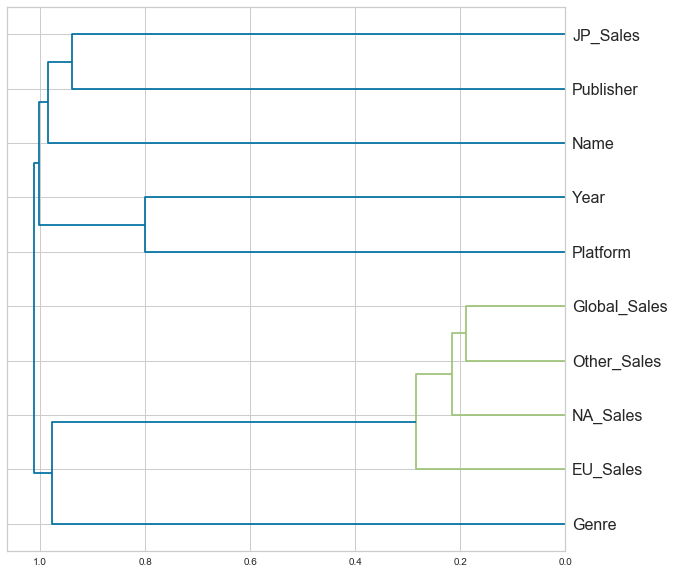

In [53]:
corr = np.round(scipy.stats.spearmanr(df_hc).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(10,10))
dendrogram = hc.dendrogram(z, labels=df_hc.columns, orientation='left', leaf_font_size=16)
plt.savefig('dendogram_vg_all.png', bbox_inches='tight')

#### Feature importance (all)

In [80]:
df = df_raw.dropna()

In [81]:
keep_cols = ['Platform', 'Genre', 'Publisher']

In [107]:
year = 'all'
rank = 4000
# Using rank = 4000 only take the top fourth of games in global sales more recent than 2013
df_split = df[((df['Rank'] < rank).values)]

In [103]:
x_train, x_valid, y_train, y_valid = train_test_split(pd.get_dummies(df_split[keep_cols]),
                                                    df_split['Global_Sales'],
                                                    train_size=0.9999,
                                                    random_state=0)

In [104]:
m_strat = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, 
                                 max_features=0.2, n_jobs=-1, oob_score=True, 
                                 bootstrap=True);
m_strat.fit(x_train, y_train);
print(m_strat.score(x_train, y_train))
print(m_strat.oob_score_)

0.24724366920311566
0.1485247016231086


In [105]:
%time fi_oob = oob_importances(m_strat, pd.DataFrame(x_train.values, columns=x_train.columns), y_train)

CPU times: user 57 s, sys: 347 ms, total: 57.3 s
Wall time: 57.5 s


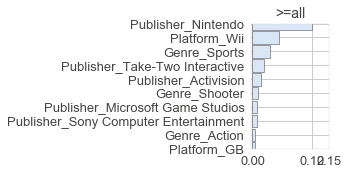

In [101]:
viz = plot_importances(fi_oob[:10], minheight=2.6, width=5, 
                       label_fontsize=13, title='>='+str(year))
# viz.save('fi_' + str(year)+'.png')

#### Feature importance (>= 2008)

In [61]:
keep_cols = ['Platform', 'Genre', 'Publisher']

In [74]:
year = 2008
rank = 5000
# Using rank = 5000 only take the top third of games in global sales greater than 2008
df_split = df[((df['Rank'] < rank).values & (df['Year'] >= year).values)]

In [75]:
x_train, x_valid, y_train, y_valid = train_test_split(pd.get_dummies(df_split[keep_cols]),
                                                    df_split['Global_Sales'],
                                                    train_size=0.9999,
                                                    random_state=0)

In [79]:
m_strat = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, 
                                 max_features=0.2, n_jobs=-1, oob_score=True, 
                                 bootstrap=True);
m_strat.fit(x_train, y_train);
print(m_strat.score(x_train, y_train))
print(m_strat.oob_score_)

0.2458413155233874
0.1366902212606258


In [65]:
%time fi_oob = oob_importances(m_strat, pd.DataFrame(x_train.values, columns=x_train.columns), y_train)

CPU times: user 1min 14s, sys: 275 ms, total: 1min 14s
Wall time: 1min 14s


In [67]:
%time fi_oob = oob_importances(m_strat, pd.DataFrame(x_train.values, columns=x_train.columns), y_train)

CPU times: user 5.17 s, sys: 43 ms, total: 5.21 s
Wall time: 5.23 s


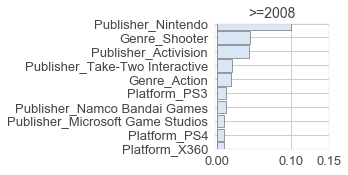

In [68]:
viz = plot_importances(fi_oob[:10], minheight=2.6, width=5, 
                       label_fontsize=13, title='>='+str(year))
# viz.save('fi_' + str(year)+'.png')

#### Feature importance (>= 2013)

In [29]:
keep_cols = ['Platform', 'Genre', 'Publisher']

In [69]:
year = 2013
rank = 8000
# Using rank = 8000 only take the top half of games in global sales more recent than 2013
df_split = df[((df['Rank'] < rank).values & (df['Year'] >= year).values)]

In [70]:
x_train, x_valid, y_train, y_valid = train_test_split(pd.get_dummies(df_split[keep_cols]),
                                                    df_split['Global_Sales'],
                                                    train_size=0.9999,
                                                    random_state=0)

In [71]:
m_strat = RandomForestRegressor(n_estimators=100, min_samples_leaf=2, 
                                 max_features=0.7, n_jobs=-1, oob_score=True, 
                                 bootstrap=True);
m_strat.fit(x_train, y_train);
print(m_strat.score(x_train, y_train))
print(m_strat.oob_score_)

0.47282132529178983
0.18514545230898083


In [72]:
%time fi_oob = oob_importances(m_strat, pd.DataFrame(x_train.values, columns=x_train.columns), y_train)

CPU times: user 1.65 s, sys: 21.4 ms, total: 1.67 s
Wall time: 1.68 s


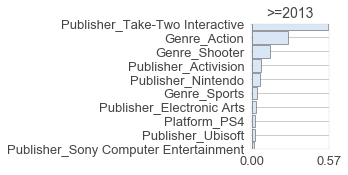

In [73]:
viz = plot_importances(fi_oob[:10], minheight=2.6, width=5, 
                       label_fontsize=13, title='>='+str(year))
# viz.save('fi_' + str(year)+'.png')

## Conclusions

### Summary

1. Markets differ in Genres, Platforms, and Publishers  
  a. EU and NA prefers Console (JP prefers handheld)  
  b. EU PC gaming is more popular  
  c. JP pubs make games just for their market  
2. Action genre is trending across all markets  
3. Success Indicators  
  a. Genre (Action, Shooter, Sports)  
  b. In Japan, the Publisher  


### Recommendations

1. Japan market game recommendations  
  a. Role playing or Fighting game (recent years popular games not released)      
2. Worldwide market game recommendations
  a. Develop franchise sports game

### Further actions

TODO: Look at the release of consoles in relation to game sales but need more detailed info regarding the time of sales.